# Finding Errors in the Conll 2003 NER dataset

In this notebook, we'll walk through identifying potential errors in the Conll 2003 NER dataset.
We'll load up the Conll data into Recon using the huggingface [datasets](https://huggingface.co/docs/datasets/index) library and walk through a standard debugging process with Recon.

We'll discuss:

1. Stats
2. Entity Coverage
3. Label Disparities
4. Prediction Errors
5. Hardest Examples

First, lets load up the Corpus using the `load_dataset` function from `datasets` and the `Dataset.from_hf_dataset` loader in Recon

In [2]:
from recon import Corpus, Dataset
from recon import get_ner_stats, get_entity_coverage
from recon.insights import get_label_disparities, top_label_disparities

In [3]:
from datasets import load_dataset, Dataset as HFDataset

In [4]:
conll2003 = load_dataset("conll2003")

Reusing dataset conll2003 (/Users/kabirkhan/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
conll_labels = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]

In [6]:
train_ds = Dataset("train").from_hf_dataset(conll2003["train"], labels=conll_labels)
dev_ds = Dataset("dev").from_hf_dataset(conll2003["validation"], labels=conll_labels)
test_ds = Dataset("test").from_hf_dataset(conll2003["test"], labels=conll_labels)

In [7]:
corpus = Corpus("conll2003", train_ds, dev_ds, test_ds)
print(corpus)

## 1. Stats

First we'll look at the basic stats of the each split in the Corpus using `Corpus.summary`. 
Under the hood, `summary` runs the `recon.stats.get_ner_stats` function across each Dataset

In [8]:
corpus.summary()

Dataset
Name: train
Stats: {
    "n_examples": 14042,
    "n_examples_no_entities": 2910,
    "n_annotations": 23499,
    "n_annotations_per_type": {
        "LOC": 7140,
        "PER": 6600,
        "ORG": 6321,
        "MISC": 3438
    },
    "examples_with_type": null
}
Dataset
Name: dev
Stats: {
    "n_examples": 3251,
    "n_examples_no_entities": 646,
    "n_annotations": 5942,
    "n_annotations_per_type": {
        "PER": 1842,
        "LOC": 1837,
        "ORG": 1341,
        "MISC": 922
    },
    "examples_with_type": null
}
Dataset
Name: test
Stats: {
    "n_examples": 3454,
    "n_examples_no_entities": 698,
    "n_annotations": 5648,
    "n_annotations_per_type": {
        "LOC": 1668,
        "ORG": 1661,
        "PER": 1617,
        "MISC": 702
    },
    "examples_with_type": null
}


Just based on the stats above, we'd probably expect our model to do better on the `LOC` label than the `MISC` label since we have almost twice the labels for `LOC`.

Let's dive into dataset statistics a bit more granularly and look at Entity Coverage

## 2. Entity Coverage

Entity Coverage looks at individual annotation spans and aggregates and sorts them. Looking at the extremes (start and end) for the Entity Coverage can tell you a lot about your Dataset.

In [13]:
train_ecs = get_entity_coverage(corpus.train, case_sensitive=True)

**Most** covered entity spans

It's no surprise that common locations are our most covered entity spans. If we train a model, we'd expect these entities to be easy to identify.

In [14]:
train_ecs[:10]

[EntityCoverage(text='U.S.', label='LOC', count=303, examples=[]),
 EntityCoverage(text='Germany', label='LOC', count=141, examples=[]),
 EntityCoverage(text='Britain', label='LOC', count=133, examples=[]),
 EntityCoverage(text='Australia', label='LOC', count=130, examples=[]),
 EntityCoverage(text='England', label='LOC', count=123, examples=[]),
 EntityCoverage(text='France', label='LOC', count=122, examples=[]),
 EntityCoverage(text='Spain', label='LOC', count=110, examples=[]),
 EntityCoverage(text='Italy', label='LOC', count=98, examples=[]),
 EntityCoverage(text='LONDON', label='LOC', count=93, examples=[]),
 EntityCoverage(text='Russian', label='MISC', count=92, examples=[])]

**Least** covered entity spans

In [15]:
train_ecs[-10:]

[EntityCoverage(text='Luca Cadalora', label='PER', count=1, examples=[]),
 EntityCoverage(text='Alex Criville', label='PER', count=1, examples=[]),
 EntityCoverage(text='Scott Russell', label='PER', count=1, examples=[]),
 EntityCoverage(text='Tadayuki Okada', label='PER', count=1, examples=[]),
 EntityCoverage(text='Carlos Checa', label='PER', count=1, examples=[]),
 EntityCoverage(text='Alexandre Barros', label='PER', count=1, examples=[]),
 EntityCoverage(text='Shinichi Itoh', label='PER', count=1, examples=[]),
 EntityCoverage(text='Swe', label='LOC', count=1, examples=[]),
 EntityCoverage(text='Bob May', label='PER', count=1, examples=[]),
 EntityCoverage(text='Bradley Hughes', label='PER', count=1, examples=[])]

In [17]:
lds = top_label_disparities(corpus.train)

In [18]:
lds

[LabelDisparity(label1='ORG', label2='LOC', count=93, examples=[]),
 LabelDisparity(label1='LOC', label2='ORG', count=93, examples=[]),
 LabelDisparity(label1='ORG', label2='PER', count=16, examples=[]),
 LabelDisparity(label1='PER', label2='ORG', count=16, examples=[]),
 LabelDisparity(label1='PER', label2='LOC', count=12, examples=[]),
 LabelDisparity(label1='LOC', label2='PER', count=12, examples=[]),
 LabelDisparity(label1='MISC', label2='LOC', count=7, examples=[]),
 LabelDisparity(label1='LOC', label2='MISC', count=7, examples=[]),
 LabelDisparity(label1='ORG', label2='MISC', count=6, examples=[]),
 LabelDisparity(label1='MISC', label2='ORG', count=6, examples=[]),
 LabelDisparity(label1='MISC', label2='PER', count=1, examples=[]),
 LabelDisparity(label1='PER', label2='MISC', count=1, examples=[])]

In [19]:
from typing import Tuple
import numpy as np
import seaborn as sns
from recon.types import LabelDisparity

def plot_cm(cm: np.array, labels: List[str]):
    labels = np.asarray(list(labels))
    print(cm, labels)
    return sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="Blues")

def get_lds_cm(label_disparities: List[LabelDisparity]) -> Tuple[List[str], np.array]:
    labels = set()
    for ld in lds:
        labels.add(ld.label1)
        labels.add(ld.label2)
    labels_map = {l:i for i, l in enumerate(labels)}
    K = len(labels)
    result = np.zeros((K, K))
    for ld in lds:
        result[labels_map[ld.label1]][labels_map[ld.label2]] = ld.count
    return labels, result

[[ 0.  7.  1.  6.]
 [ 7.  0. 12. 93.]
 [ 1. 12.  0. 16.]
 [ 6. 93. 16.  0.]] ['MISC' 'LOC' 'PER' 'ORG']


<AxesSubplot:>

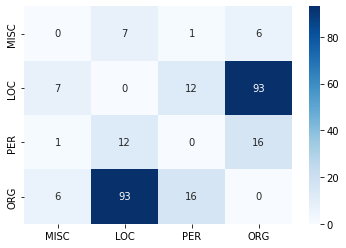

In [20]:
labels, cm = get_lds_cm(lds)
plot_cm(cm, labels=labels)

In [22]:
corpus.to_disk("./data/conll2003", overwrite=True)

In [24]:
corpus.train_ds.to_spacy("./data/conll2003")
corpus.dev_ds.to_spacy("./data/conll2003")

In [26]:
!spacy train config/config.cfg --paths.train ./data/conll2003/train.spacy --paths.dev ./data/conll2003/dev.spacy --output ./models/en_conll_sm

✔ Created output directory: models/en_conll_sm
ℹ Saving to output directory: models/en_conll_sm
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-04-25 12:11:45,709] [INFO] Set up nlp object from config
[2022-04-25 12:11:45,713] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-25 12:11:45,715] [INFO] Created vocabulary
[2022-04-25 12:11:45,716] [INFO] Finished initializing nlp object
[2022-04-25 12:11:50,458] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     44.28    0.00    0.00    0.00    0.00
  0     200         82.58   2838.65   52.41   60.56   46.20    0.52
  0     400       1039.30   2465.74   63.43   64.10 

In [27]:
from recon.recognizer import SpacyEntityRecognizer

In [28]:
nlp = spacy.load("models/en_conll_sm/model-last/")
rec = SpacyEntityRecognizer(nlp)

In [34]:
from recon.insights import top_prediction_errors, get_hardest_examples

In [37]:
pe = top_prediction_errors(rec, corpus.dev, verbose=True)
pe[0]


=============================== Error Analysis ===============================

N Examples         3251
N Errors           947 
N Error Examples   709 
Error Rate         0.22



PredictionError(text='Pirelli', true_label='ORG', pred_label='PER', count=9, examples=[PredictionErrorExamplePair(original=Example(text='Pirelli cables look to tap Chinese growth . ', spans=[Span(text='Pirelli', start=0, end=7, label='ORG', token_start=None, token_end=None, kb_id=None), Span(text='Chinese', start=27, end=34, label='MISC', token_start=None, token_end=None, kb_id=None)], tokens=[Token(text='Pirelli', start=0, end=7, id=0), Token(text='cables', start=8, end=14, id=1), Token(text='look', start=15, end=19, id=2), Token(text='to', start=20, end=22, id=3), Token(text='tap', start=23, end=26, id=4), Token(text='Chinese', start=27, end=34, id=5), Token(text='growth', start=35, end=41, id=6), Token(text='.', start=42, end=43, id=7)], meta={}, formatted=True), predicted=Example(text='Pirelli cables look to tap Chinese growth . ', spans=[Span(text='Pirelli', start=0, end=7, label='PER', token_start=0, token_end=1, kb_id=None), Span(text='Chinese', start=27, end=34, label='MISC', t

In [ ]:
he = get_hardest_examples(rec, corpus.dev)

In [32]:
he[0].reference.show()

In [33]:
he[0].prediction.show()

In [39]:
corpus.dev_ds.to_prodigy()

Saving dataset to prodigy dataset: dev_671418edc919b3e9


ModuleNotFoundError: No module named 'prodigy'